In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# importing required libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras import regularizers
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pickle

Using TensorFlow backend.


In [2]:
# reading datasets
project_data = pd.read_csv("drive/My Drive/Donors for AFR Classroom/train_data.csv")
project_data.head()

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1


In [3]:
project_data["project_is_approved"].value_counts()

1    92706
0    16542
Name: project_is_approved, dtype: int64

In [4]:
resources = pd.read_csv("drive/My Drive/Donors for AFR Classroom/resources.csv")
resources.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [0]:
# We will combine these two datasets based on the id

price_data = resources.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [0]:
# It can been seen that there are some emtpy cells both for project_essay_3 and project_essay_4
# We will combine all the project essay columns into one single feature

project_data["text"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [0]:
project_data = project_data.drop(["project_essay_1","project_essay_2","project_essay_3","project_essay_4","project_title"],axis=1)

In [0]:
# We clean the essay text data
# For this task, we have defined some helper functions
# The same function and code snippet will be used to clean project title
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [9]:
# Cleaning Text feature
preprocessed_text = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['text'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_text.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:01<00:00, 1782.70it/s]


In [0]:
project_data["clean_text"] = preprocessed_text

In [11]:
project_data["clean_text"][:5]

0    my students english learners working english s...
1    our students arrive school eager learn they po...
2    true champions not always ones win guts by mia...
3    i work unique school filled esl english second...
4    our second grade classroom next year made arou...
Name: clean_text, dtype: object

In [0]:
project_data = project_data.drop(['Unnamed: 0', 'id', 'teacher_id',
                                  'project_submitted_datetime','text'],axis=1)

In [0]:
# we have categorical features also, will do cleaning one by one

# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()


project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()


project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()


project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()

project_data['school_state'] = project_data['school_state'].str.lower()

In [14]:
project_data.head()

,teacher_prefix,school_state,project_grade_category,project_subject_categories,project_subject_subcategories,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_text
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,My students need opportunities to practice beg...,0,0,154.60,23,my students english learners working english s...
1,mr,fl,grades_6_8,history_civics_health_sports,civics_government_teamsports,My students need a projector to help with view...,7,1,299.00,1,our students arrive school eager learn they po...
2,ms,az,grades_6_8,health_sports,health_wellness_teamsports,"My students need shine guards, athletic socks,...",1,0,516.85,22,true champions not always ones win guts by mia...
3,mrs,ky,grades_prek_2,literacy_language_math_science,literacy_mathematics,My students need to engage in Reading and Math...,4,1,232.90,4,i work unique school filled esl english second...
4,mrs,tx,grades_prek_2,math_science,mathematics,My students need hands on practice in mathemat...,1,1,67.98,4,our second grade classroom next year made arou...


In [15]:
# we will extract numerical digits from the project resource summary

project_summary_numerical = []
for sentance in tqdm(project_data['project_resource_summary']):
    sent1 = decontracted(sentance)
    sent1 = ' '.join(e for e in sent1.split() if e.isdigit())
    k=len(sent1)
    project_summary_numerical.append(k)

project_data["project_summary_numerical"] = project_summary_numerical

100%|██████████| 109248/109248 [00:01<00:00, 68460.21it/s]


In [0]:
target = project_data["project_is_approved"]
features = project_data.drop(["project_resource_summary","project_is_approved"],axis=1)

In [0]:
# We split our dataset into train,cross-validation and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target,test_size=0.30,random_state=123)

In [18]:
print(X_train.shape)
print("+++++++++++++")
print(X_test.shape)

(76473, 10)
+++++++++++++
(32775, 10)


In [0]:
# Preparing Text Data As per Our Model

X_train["len_text"] = X_train["clean_text"].apply(len)
X_test["len_text"] = X_test["clean_text"].apply(len)

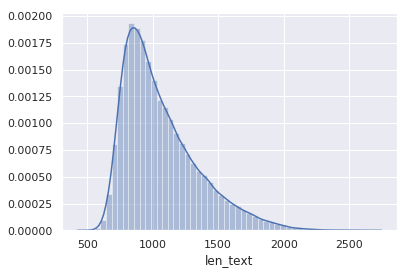

In [20]:
sns.set()
ax = sns.distplot(X_train["len_text"])

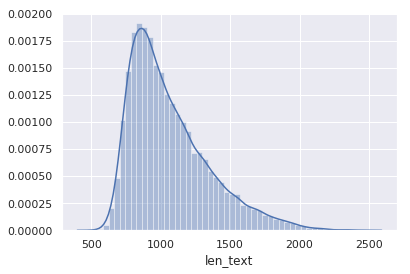

In [21]:
ax = sns.distplot(X_test["len_text"])

In [0]:
MAX_SEQUENCE_LENGTH = 800
MAX_VOCAB_SIZE = 1000000
EMBEDDING_DIM = 300

In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train["clean_text"].tolist())
sequences_train = tokenizer.texts_to_sequences(X_train["clean_text"])
sequences_test = tokenizer.texts_to_sequences(X_test["clean_text"])

In [24]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 49064 unique tokens.


In [25]:
encoded_train = pad_sequences(sequences_train,maxlen=MAX_SEQUENCE_LENGTH,padding='post', truncating='post')
print('Shape of data tensor:', encoded_train.shape)

Shape of data tensor: (76473, 800)


In [26]:
encoded_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH,padding='post', truncating='post')
print('Shape of data tensor:', encoded_test.shape)

Shape of data tensor: (32775, 800)


In [0]:
# Loading Embedding File

pickle_in = open("drive/My Drive/Donors for AFR Classroom/glove_vectors","rb")
glove_words = pickle.load(pickle_in)

In [28]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, 300))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector


print(num_words)
print("+++++++++")
print(embedding_matrix.shape)

49065
+++++++++
(49065, 300)


In [29]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  300,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)
input_text = Input(shape=(MAX_SEQUENCE_LENGTH,),name="input_text")
x = embedding_layer(input_text)
x = LSTM(128,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x) # dropout=0.5
# x = SpatialDropout1D(0.5)(x)
flatten_1 = Flatten()(x)

W0813 20:09:28.506829 139804349007744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 20:09:28.525328 139804349007744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 20:09:28.528237 139804349007744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 20:09:28.540262 139804349007744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0813 20:09:28.542618 1398043490

In [30]:
# Now will prepare all the remaining categorical features
# Teacher Prefix
no_of_unique_prefix  = X_train["teacher_prefix"].nunique()
embedding_size_prefix = int(min(np.ceil((no_of_unique_prefix)/2), 50 ))
print('Unique Categories:', no_of_unique_prefix,'Embedding Size:', embedding_size_prefix)


# Defining Input and Embedding Layer for the same

input_prefix = Input(shape=(1,),name="teacher_prefix")
embedding_prefix = Embedding(no_of_unique_prefix,embedding_size_prefix,name="emb_pre",trainable=True)(input_prefix)
flatten_2 = Flatten()(embedding_prefix)

lb = LabelEncoder()
encoder_prefix_train = lb.fit_transform(X_train["teacher_prefix"])
# encoder_prefix_cv = lb.transform(X_cv["teacher_prefix"])
encoder_prefix_test = lb.transform(X_test["teacher_prefix"])

Unique Categories: 5 Embedding Size: 3


In [31]:
# School State
no_of_unique_state  = X_train["school_state"].nunique()
embedding_size_state= int(min(np.ceil((no_of_unique_state)/2), 50 ))
print('Unique Categories:', no_of_unique_state,'Embedding Size:', embedding_size_state)


# Defining Input and Embedding Layer for the same

input_state = Input(shape=(1,),name="school_prefix")
embedding_state = Embedding(no_of_unique_state,embedding_size_state,name="emb_state",trainable=True)(input_state)
flatten_3 = Flatten()(embedding_state)


encoder_state_train = lb.fit_transform(X_train["school_state"])
# encoder_state_cv = lb.transform(X_cv["school_state"])
encoder_state_test = lb.transform(X_test["school_state"])

Unique Categories: 51 Embedding Size: 26


In [32]:
# For project_grade_category
no_of_unique_grade  = X_train["project_grade_category"].nunique()
embedding_size_grade = int(min(np.ceil((no_of_unique_grade)/2), 50 ))
print('Unique Categories:', no_of_unique_grade,'Embedding Size:', embedding_size_grade)


# Defining Input and Embedding Layer for the same

input_grade= Input(shape=(1,),name="grade_cat")
embedding_grade = Embedding(no_of_unique_grade,embedding_size_grade,name="emb_grade",trainable=True)(input_grade)
flatten_4 = Flatten()(embedding_grade)


encoder_grade_train = lb.fit_transform(X_train["project_grade_category"])
# encoder_grade_cv = lb.transform(X_cv["project_grade_category"])
encoder_grade_test = lb.transform(X_test["project_grade_category"])

Unique Categories: 4 Embedding Size: 2


In [33]:
# For project_subject_categories
no_of_unique_subcat  = X_train["project_subject_categories"].nunique()
embedding_size_subcat = int(min(np.ceil((no_of_unique_subcat)/2), 50 ))
print('Unique Categories:', no_of_unique_subcat,'Embedding Size:', embedding_size_subcat)


# Defining Input and Embedding Layer for the same

input_subcat= Input(shape=(1,),name="sub_cat")
embedding_subcat = Embedding(no_of_unique_subcat,embedding_size_subcat,name="emb_subcat",trainable=True)(input_subcat)
flatten_5 = Flatten()(embedding_subcat)


# encoder_subcat_train = lb.fit_transform(X_train["project_subject_categories"])
# encoder_subcat_cv = lb.transform(X_cv["project_subject_categories"])
# encoder_subcat_test = lb.transform(X_test["project_subject_categories"])
le = LabelEncoder()
le.fit(X_train["project_subject_categories"])
X_test["project_subject_categories"] = X_test["project_subject_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
# X_cv["project_subject_categories"] = X_cv["project_subject_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
encoder_subcat_train = le.transform(X_train["project_subject_categories"])
encoder_subcat_test= le.transform(X_test["project_subject_categories"])
# encoder_subcat_cv = le.transform(X_cv["project_subject_categories"])

Unique Categories: 51 Embedding Size: 26


In [34]:
# For project_subject_subcategories
no_of_unique_subcat_1  = X_train["project_subject_subcategories"].nunique()
embedding_size_subcat_1 = int(min(np.ceil((no_of_unique_subcat_1)/2), 50 ))
print('Unique Categories:', no_of_unique_subcat_1,'Embedding Size:', embedding_size_subcat_1)

# Defining Input and Embedding Layer for the same

input_subcat_1= Input(shape=(1,),name="sub_cat_1")
embedding_subcat_1 = Embedding(no_of_unique_subcat_1,embedding_size_subcat_1,name="emb_subcat_1",trainable=True)(input_subcat_1)
flatten_6 = Flatten()(embedding_subcat_1)


le = LabelEncoder()
le.fit(X_train["project_subject_subcategories"])
X_test["project_subject_subcategories"] = X_test["project_subject_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
# X_cv["project_subject_subcategories"] = X_cv["project_subject_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
encoder_subcat_1_train = le.transform(X_train["project_subject_subcategories"])
encoder_subcat_1_test= le.transform(X_test["project_subject_subcategories"])
# encoder_subcat_1_cv = le.transform(X_cv["project_subject_subcategories"])

Unique Categories: 391 Embedding Size: 50


In [0]:
# Now we will prepare numerical features for our model
num_train_1=X_train['project_summary_numerical'].values.reshape(-1, 1)
num_train_2=X_train['price'].values.reshape(-1, 1)
num_train_3=X_train['quantity'].values.reshape(-1, 1)
num_train_4=X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_test_1=X_test['project_summary_numerical'].values.reshape(-1, 1)
num_test_2=X_test['price'].values.reshape(-1, 1)
num_test_3=X_test['quantity'].values.reshape(-1, 1)
num_test_4=X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)


num_train=np.concatenate((num_train_1,num_train_2,num_train_3,num_train_4),axis=1)

num_test=np.concatenate((num_test_1,num_test_2,num_test_3,num_test_4),axis=1)


In [0]:
from sklearn.preprocessing import StandardScaler
norm=StandardScaler()
norm_train=norm.fit_transform(num_train)
norm_test=norm.transform(num_test)

In [0]:
# Defining the Input and Embedding Layer for the same

num_feats = Input(shape=(4,),name="numerical_features")
num_feats_ = Dense(100,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(num_feats)

In [38]:
print("Building Model-1")
x_concatenate = concatenate([flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,num_feats_])
# x_concatenate = BatchNormalization()(x_concatenate)
x = Dense(128,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_concatenate)
# x=LeakyReLU(alpha=0.3)(x)
x=Dropout(0.5)(x)
x = Dense(256,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
# x=LeakyReLU(alpha=0.3)(x)
x=Dropout(0.5)(x)
x = Dense(64,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
# x=LeakyReLU(alpha=0.3)(x)
output = Dense(2, activation='softmax', name='output')(x)
model_1 = Model(inputs=[input_text,input_prefix,input_state,input_grade,
                        input_subcat,input_subcat_1,num_feats],outputs=[output])

Building Model-1


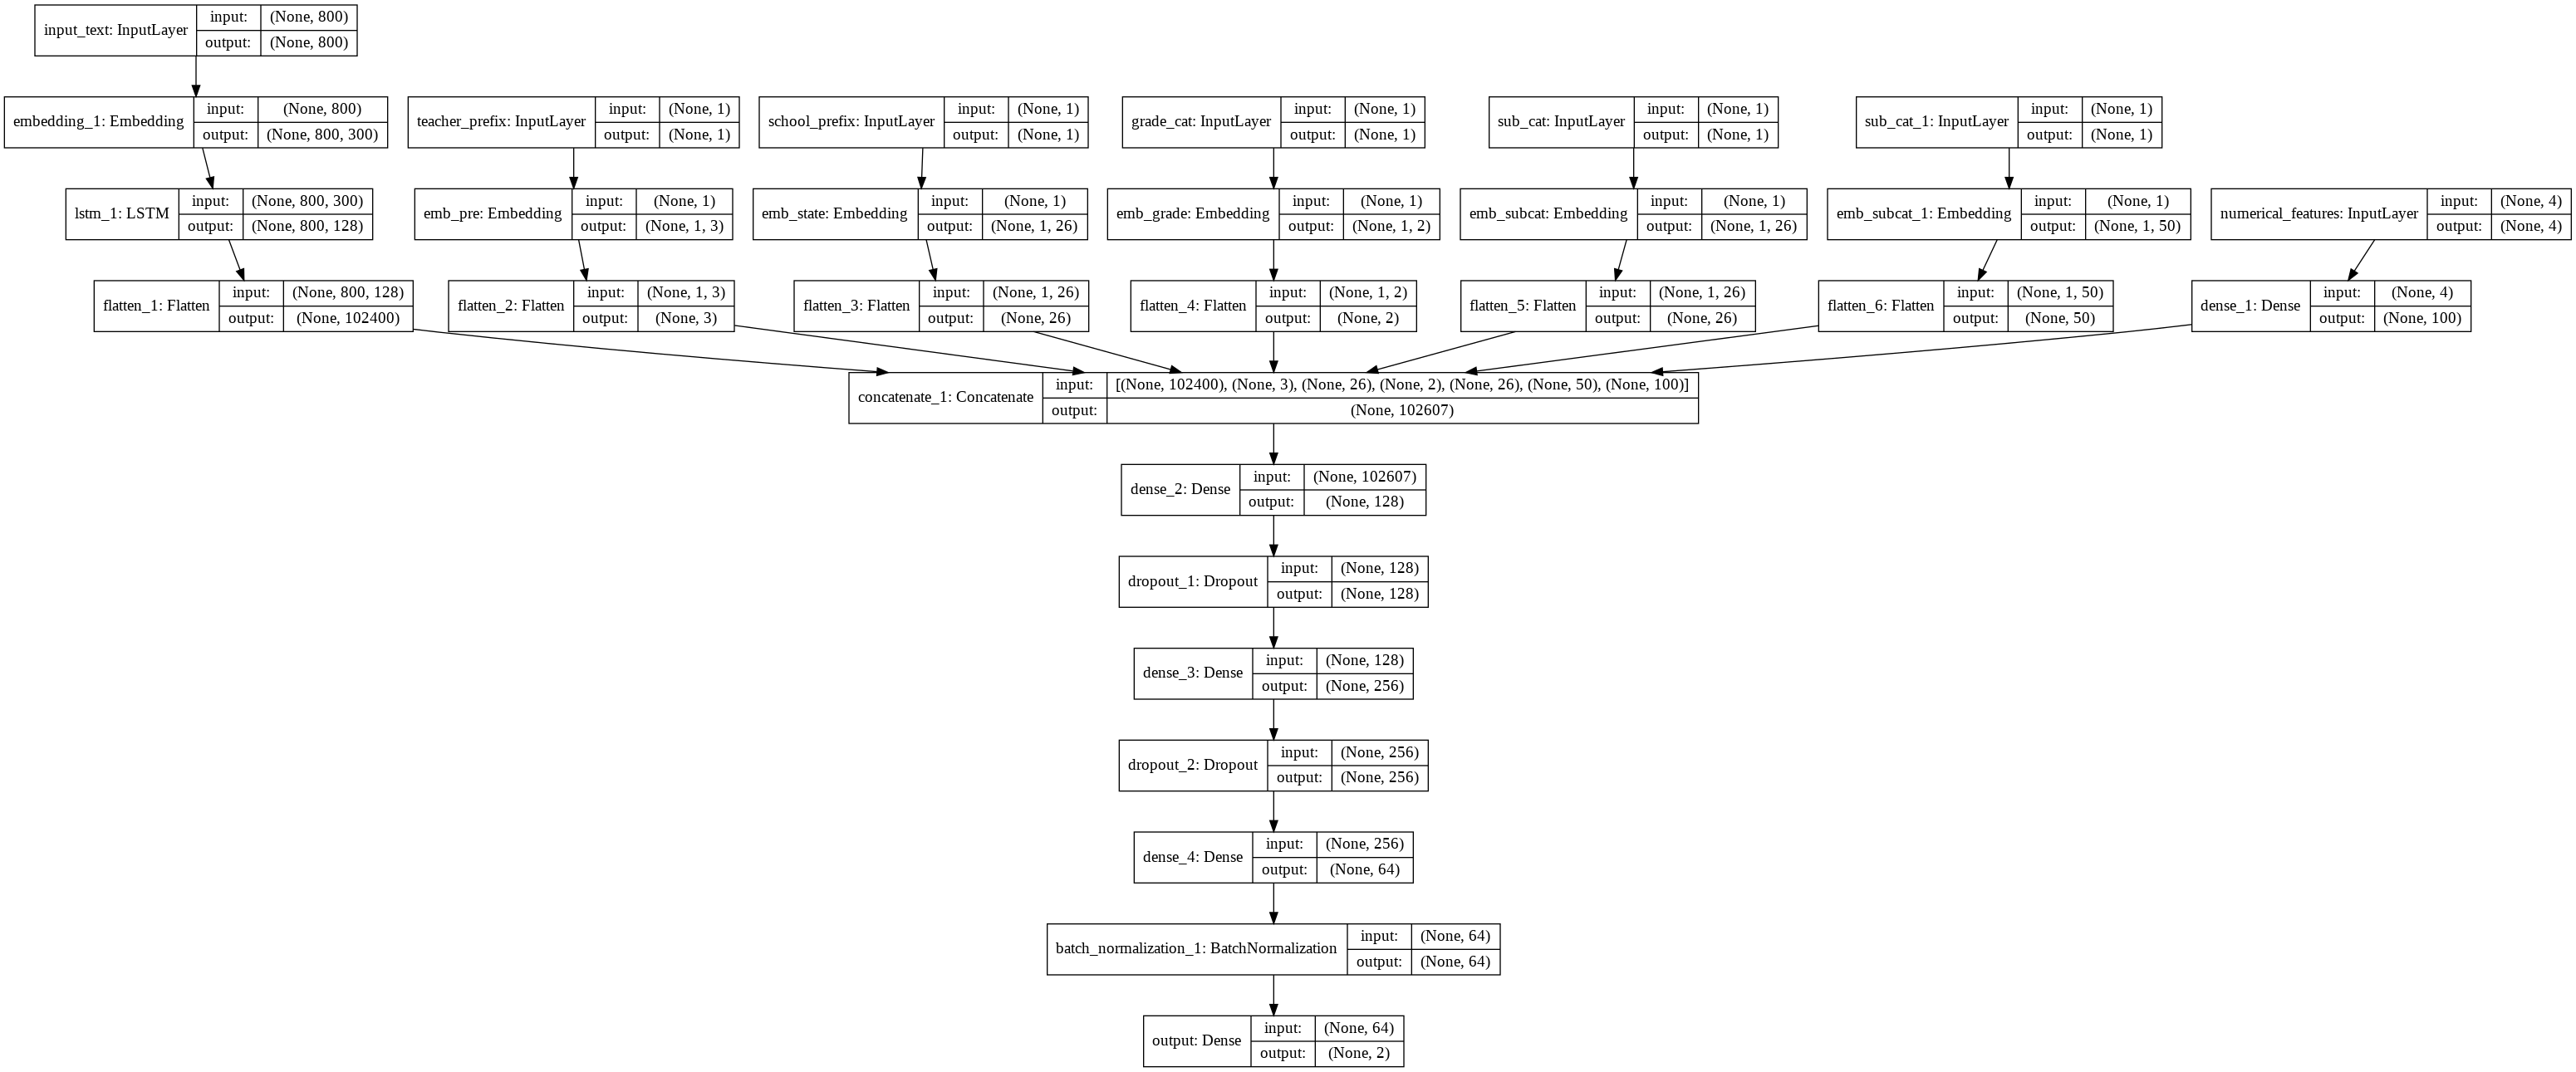

In [39]:
# https://github.com/mmortazavi/EntityEmbedding-Working_Example/blob/master/EntityEmbedding.ipynb
from keras.utils import plot_model
import pydot_ng as pydot
plot_model(model_1, show_shapes=True, show_layer_names=True, to_file='model_1.png')
from IPython.display import Image
Image(retina=True, filename='model_1.png')

In [0]:
train_data_1 = [encoded_train,encoder_prefix_train,encoder_state_train,
              encoder_grade_train,encoder_subcat_train,encoder_subcat_1_train,norm_train]
test_data_1 = [encoded_test,encoder_prefix_test,encoder_state_test,encoder_grade_test,
             encoder_subcat_test,encoder_subcat_1_test,norm_test]

from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)

In [0]:
checkpoint_1 = ModelCheckpoint("model_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop_1 = EarlyStopping(monitor = 'val_loss', 
                            mode="min",
                            min_delta = 0, 
                            patience = 2,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr_1 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta = 0.0001)

tensorboard_1 = TensorBoard(log_dir='graph_1', histogram_freq=0, batch_size=512, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

callbacks_1 = [checkpoint_1,earlystop_1,tensorboard_1,reduce_lr_1]

In [0]:
# Defining Custom ROC-AUC Metrics
from sklearn.metrics import roc_auc_score

def auc1(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return tf.py_func(auc1, (y_true, y_pred), tf.double)

In [0]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [44]:
model_1.compile(optimizer=adam, loss='categorical_crossentropy', metrics=[auroc])

W0813 20:09:32.830842 139804349007744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0813 20:09:32.864208 139804349007744 deprecation.py:323] From <ipython-input-42-a7e6cba44e56>:10: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable,

In [45]:
history_1 = model_1.fit(train_data_1,Y_train,batch_size=512,
                        epochs=20,validation_data=(test_data_1,Y_test),callbacks=callbacks_1)

W0813 20:09:33.083955 139804349007744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 76473 samples, validate on 32775 samples


W0813 20:09:35.783294 139804349007744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0813 20:09:35.785117 139804349007744 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
76473/76473 [==============================] - 308s 4ms/step - loss: 1.4023 - auroc: 0.5161 - val_loss: 0.9405 - val_auroc: 0.5841

Epoch 00001: val_loss improved from inf to 0.94046, saving model to model_1.h5
Epoch 2/20
76473/76473 [==============================] - 303s 4ms/step - loss: 0.8007 - auroc: 0.6250 - val_loss: 0.7211 - val_auroc: 0.7198

Epoch 00002: val_loss improved from 0.94046 to 0.72105, saving model to model_1.h5
Epoch 3/20
76473/76473 [==============================] - 301s 4ms/step - loss: 0.6334 - auroc: 0.7141 - val_loss: 0.5979 - val_auroc: 0.7351

Epoch 00003: val_loss improved from 0.72105 to 0.59787, saving model to model_1.h5
Epoch 4/20
76473/76473 [==============================] - 300s 4ms/step - loss: 0.5455 - auroc: 0.7342 - val_loss: 0.5313 - val_auroc: 0.7477

Epoch 00004: val_loss improved from 0.59787 to 0.53135, saving model to model_1.h5
Epoch 5/20
76473/76473 [==============================] - 300s 4ms/step - loss: 0.4962 - auroc: 0.74

In [54]:
print(model_1.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         (None, 800)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 800, 300)     14719500    input_text[0][0]                 
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
school_prefix (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
grade_cat 

In [0]:
my_model = load_model("model_1.h5",custom_objects={"auroc":auroc})

In [0]:
project_status = {0:"Rejected",1:"Approved"}

In [0]:
Y_pred = my_model.predict(test_data_1,batch_size=512)

In [0]:
# took the function from https://nbviewer.jupyter.org/github/pranaya-mathur/Human-Activity-Recognition/blob/master/Human_Activity_Recognition.ipynb
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([project_status[y] for y in np.argmax(Y_test, axis=1)])
    Y_pred = pd.Series([project_status[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [59]:
results = confusion_matrix(Y_test,Y_pred)
results

Pred,Approved,Rejected
True,,
Approved,27050,762
Rejected,4041,922


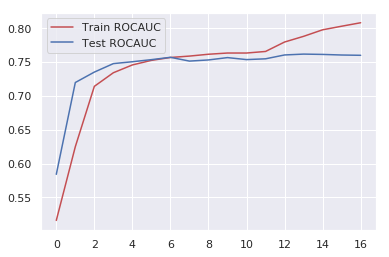

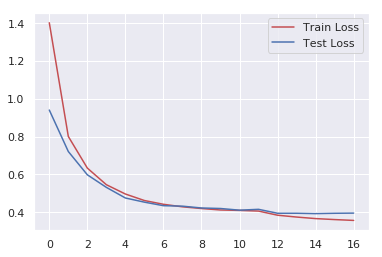

In [60]:
plt.plot(history_1.history['auroc'], 'r')
plt.plot(history_1.history['val_auroc'], 'b')
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})
plt.show()


plt.plot(history_1.history['loss'], 'r')
plt.plot(history_1.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

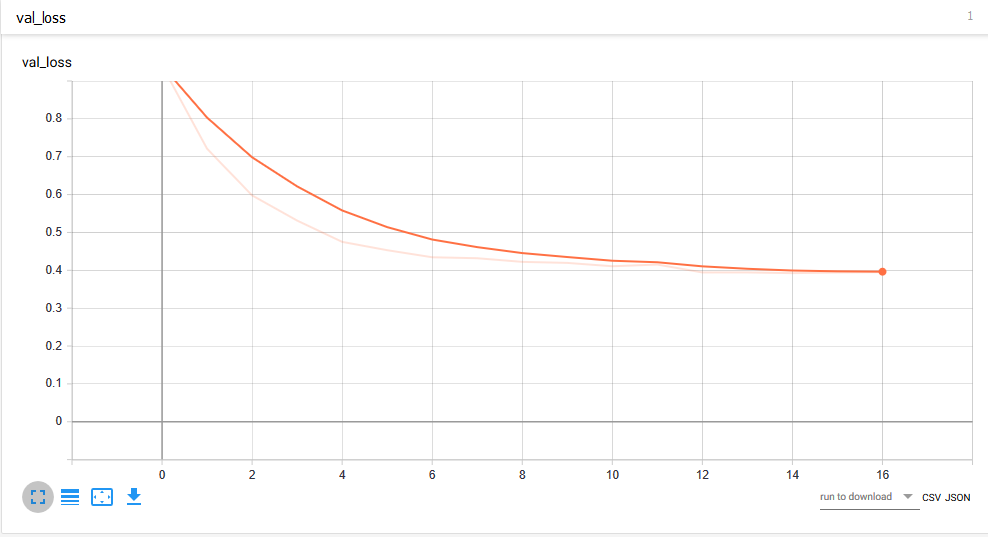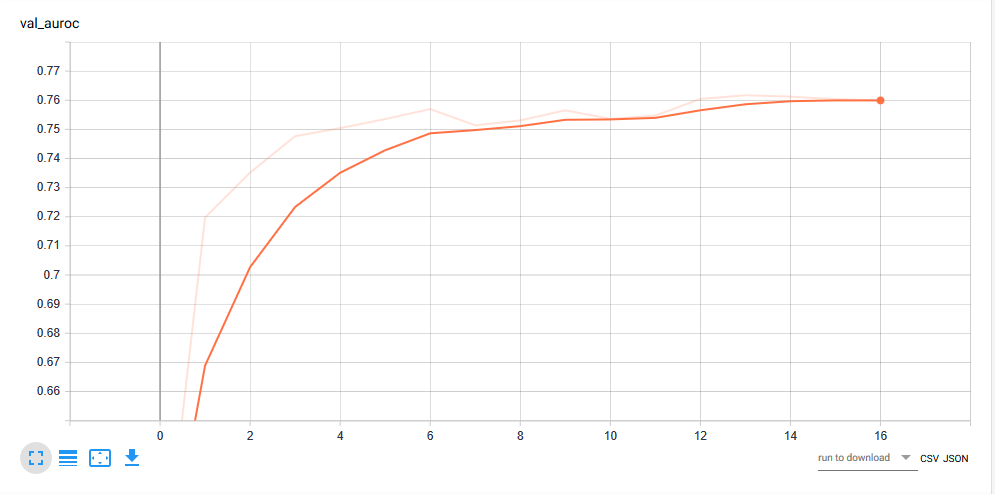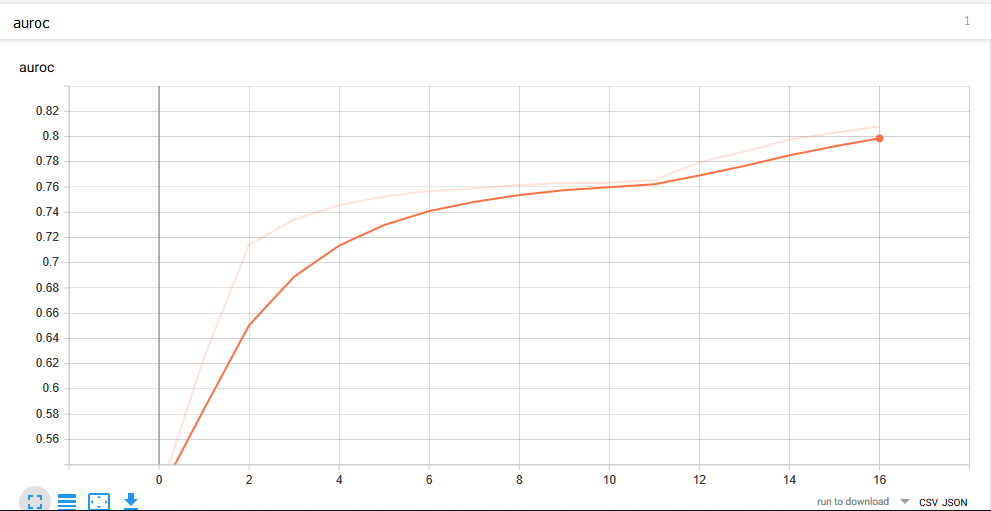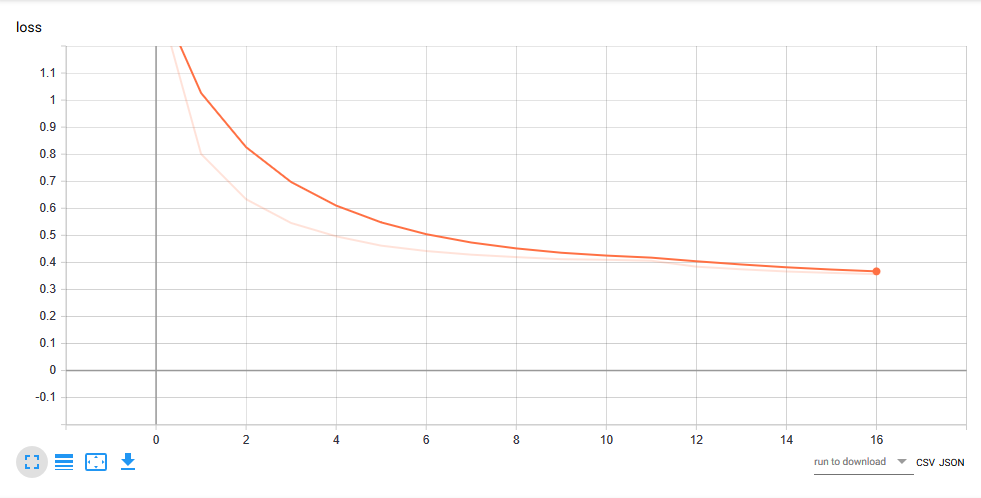

Model is overfitting... Getting only 0.76 AUC.